<a href="https://colab.research.google.com/github/Ibrahim-Ayaz/Food101-Classification-Project/blob/main/food_vision_101_classification_project_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Food Vision 101 Object Classification Project - In this notebook, we're going be running a series of machine learning experiments (5) to see if it is possible to beat the Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf

The dataset that we're going to be working with is the Food101 dataset from TensorFlow datasets - https://www.tensorflow.org/datasets/catalog/food101

## GPU access

In [ ]:
# Confirm access to a GPU
!nvidia-smi

Tue Jul  8 09:52:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   47C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Donwloading helper functions (`helper_functions.py`) for project

In [ ]:
# Download helper_functions.py script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2025-07-08 09:52:59--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-07-08 09:52:59 (17.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
# Import necessary helper functions from script
from helper_functions import plot_loss_curves, compare_historys, create_tensorboard_callback

## Downloading Food101 dataset from TensorFlow

In [ ]:
import tensorflow_datasets as tfds, tensorflow as tf
all_datasets = tfds.list_builders() # List all of the avaibale datasets in TensorFlow
print(f'food101' in all_datasets) # Verify that food101 is the dataset we're looking for

True


In [ ]:
# Load in Food101 data
(train_data, test_data), ds_info = tfds.load(name = 'food101', split = ['train', 'validation'], as_supervised = True, with_info = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.F7OCNN_2.0.0/food101-train.tfrecord*...:   0%|         …

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/incomplete.F7OCNN_2.0.0/food101-validation.tfrecord*...:   0%|    …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


## Create preprocessing functions for our data

In [ ]:
from tensorflow.keras import layers

# Define data augmentation layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
], name = 'data_augmentation')

In [ ]:
def preprocess_data(image, label, image_size = 224):
  image = tf.image.resize(image, [image_size, image_size]) # Reshape target image to 224x224
  image = tf.cast(image, dtype = tf.float32)
  image = data_augmentation(image) # Pass image through data augmentation layer
  return image, label

In [ ]:
# Get a sample image and label from dataset
for image, label in train_data.take(1):
  transformed_image = preprocess_data(image, label)

# Access the preprocessed image and label from tuple
preprocessed_image, label = transformed_image

# Print out image before and after prepcrocessing & shapes
print(f'Original image before preprocessing: \n{image[:2]}')
print(f'Original image shape: \n{image.shape}')
print(f'Original image datatype: {image.dtype}')
print(f'Preprocessed image: \n{preprocessed_image[:2]}')
print(f'Preprocessed image shape: \n{preprocessed_image.shape}')
print(f'Preprocessed image datatype: \n{preprocessed_image.dtype}')

Original image before preprocessing: 
[[[233 253 251]
  [231 253 250]
  [228 254 251]
  ...
  [ 85  82  89]
  [ 68  67  75]
  [ 57  57  67]]

 [[232 254 252]
  [229 254 251]
  [226 255 251]
  ...
  [121 116 120]
  [100  99 104]
  [ 86  85  91]]]
Original image shape: 
(512, 512, 3)
Original image datatype: <dtype: 'uint8'>
Preprocessed image: 
[[[ 86.03539   95.39833  111.06804 ]
  [ 81.26731   91.58968  112.24811 ]
  [ 73.00026   85.95603  109.79344 ]
  ...
  [236.12347  197.25575  102.01086 ]
  [232.18433  194.47562   98.82944 ]
  [231.21236  194.17421   98.00889 ]]

 [[150.72676  148.40372  134.82703 ]
  [153.93556  154.36476  142.41916 ]
  [151.76395  154.18515  143.17636 ]
  ...
  [238.04805  198.88608  106.111496]
  [229.41438  191.63219   98.988785]
  [216.67569  180.16093   88.57987 ]]]
Preprocessed image shape: 
(224, 224, 3)
Preprocessed image datatype: 
<dtype: 'float32'>


In [ ]:
for image, label in train_data.take(1):
  print(f'Label: {label.numpy()}')

Label: 56


## Turning our datasets into batches and prefetched datasets (so they run as fast as possible)

We're going to be turning our datasets into efficient data pipelines so that upon execution, they are running as fast as possbile: https://www.tensorflow.org/guide/data

In [ ]:
# Map preprocessing function, shuffle and parallelise it to training data
train_data = train_data.map(map_func = preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

# Validation/test pipeline
test_data = test_data.map(map_func = preprocess_data, num_parallel_calls = tf.data.AUTOTUNE)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

## Create a checkpoint callback for our model

In [ ]:
# Import tensorboard callback from script
from helper_functions import create_tensorboard_callback

# Setup model checkpoint path to save all of models' progress during training
checkpoint_path = 'model_checkpoint.weights.h5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path, save_weights_only = True, monitor = 'val_accuracy', save_best_only = True)

## Mixed precision training (for speeding up model performance)

Mixed training uses both `tf.float32` and `tf.float16` datatypes for speeding up a model's performance: https://www.tensorflow.org/guide/mixed_precision

In [ ]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16') # Set global data policy for mixed precision
mixed_precision.global_policy()

<DTypePolicy "mixed_float16">

## Model 1: Pretrained feature-extactor model (EfficientNetB0)


In [ ]:
from tensorflow.keras import layers

# Setup data inputs
input_size = (224, 224, 3)

# Get number of classes
num_classes = ds_info.features['label'].num_classes

# Create feature extractor model with Functional API
base_model = tf.keras.applications.EfficientNetB0(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')
base_model.trainable = False

inputs = layers.Input(shape = (224, 224, 3), name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(x)
model_1 = tf.keras.Model(inputs, outputs)

# Conmpile model
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Get model summary
model_1.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,408,584 (16.82 MB)

 Trainable params: 356,453 (1.36 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

In [ ]:
# Fit
initial_epochs = 10
history_1 = model_1.fit(train_data, epochs = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 *len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_1'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_1/20250708-100054
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 244s 91ms/step - accuracy: 0.2960 - loss: 3.1697 - val_accuracy: 0.6120 - val_loss: 1.4577
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 84ms/step - accuracy: 0.4623 - loss: 2.1737 - val_accuracy: 0.6253 - val_loss: 1.4035
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 208s 87ms/step - accuracy: 0.4867 - loss: 2.0628 - val_accuracy: 0.6419 - val_loss: 1.3437
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.4965 - loss: 1.9946 - val_accuracy: 0.6472 - val_loss: 1.3284
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 199s 83ms/step - accuracy: 0.5080 - loss: 1.9510 - val_accuracy: 0.6425 - val_loss: 1.3027
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 201s 84ms/step - accuracy: 0.5174 - loss: 1.9139 - val_accuracy: 0.6510 - val_loss: 1.2882
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 200s 83ms/step - accuracy: 0.5204 - loss: 1.8912 -

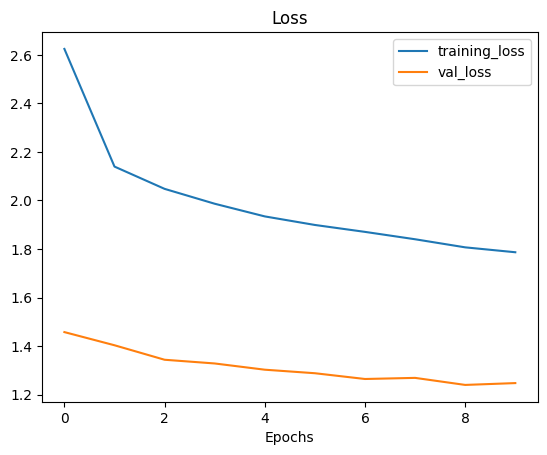

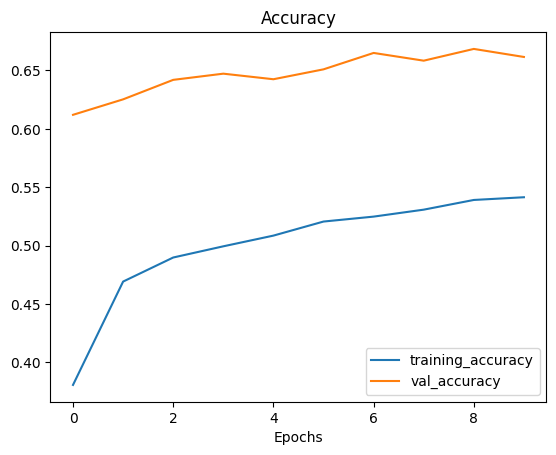

In [ ]:
# Plot model loss curves
plot_loss_curves(history = history_1)

In [ ]:
# Evaluate model on test data
model_1.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 68s 86ms/step - accuracy: 0.6648 - loss: 1.2459


[1.2509543895721436, 0.6629306674003601]

In [ ]:
# Make predictions with model
model_1_preds = model_1.predict(test_data)
model_1_preds[:1]

790/790 ━━━━━━━━━━━━━━━━━━━━ 74s 85ms/step


array([[4.753e-03, 8.345e-07, 8.053e-05, 1.013e-06, 1.824e-05, 1.717e-05,
        4.470e-06, 0.000e+00, 5.939e-03, 4.768e-07, 1.639e-04, 5.960e-08,
        4.508e-04, 6.285e-04, 8.575e-03, 4.113e-05, 2.313e-02, 9.567e-05,
        5.960e-08, 4.768e-07, 7.749e-07, 1.599e-03, 1.059e-02, 4.554e-05,
        2.384e-07, 2.205e-06, 8.345e-07, 8.315e-05, 8.643e-06, 7.056e-01,
        2.186e-03, 8.118e-05, 6.590e-04, 0.000e+00, 1.267e-04, 1.788e-06,
        3.493e-05, 1.252e-06, 0.000e+00, 2.038e-05, 2.921e-06, 2.980e-07,
        2.260e-04, 2.146e-06, 7.749e-07, 6.252e-03, 6.258e-06, 9.537e-06,
        4.172e-07, 8.047e-06, 2.384e-07, 0.000e+00, 1.788e-06, 9.239e-06,
        0.000e+00, 1.317e-05, 5.364e-06, 6.855e-06, 2.454e-02, 1.609e-06,
        2.980e-07, 3.576e-07, 4.768e-06, 7.683e-05, 0.000e+00, 4.172e-07,
        8.643e-06, 1.788e-07, 1.073e-06, 1.562e-05, 0.000e+00, 2.384e-07,
        4.745e-04, 4.925e-03, 1.073e-06, 0.000e+00, 5.126e-06, 6.199e-06,
        9.358e-06, 6.557e-07, 2.086e-0

In [ ]:
# Convert model preds to labels
labels = model_1_preds.argmax(axis = 1)
labels[:10]

array([29, 81, 91, 53, 97, 97, 10, 31,  3,  8])

In [ ]:
# Load back in model weights
loaded_model = model_1.load_weights('/content/model_checkpoint.weights.h5')
loaded_model

## Fine-tuning model 1

> 🔑 **Note:** When fine-tuning a model, you typically lower the learning so that the model slowly updates it weights when training on a similar dataset (Food101 for example for this project).

In [ ]:
# Unfreeze last 20 layers of feature-extractor model
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

# Freeze all BatchNormalization layers within the last 20 layers
for layer in base_model.layers[-20:]:
  if isinstance(layer, layers.BatchNormalization):
    layer.trainable = False

# Compile
model_1.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                metrics = ['accuracy'])

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Fit fine-tuned model
history_1_fine_tune = model_1.fit(train_data, epochs = total_epochs, initial_epoch = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_1'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_1/20250708-103729
Epoch 11/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 251s 95ms/step - accuracy: 0.5466 - loss: 1.7559 - val_accuracy: 0.6827 - val_loss: 1.1683
Epoch 12/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 204s 85ms/step - accuracy: 0.5681 - loss: 1.6711 - val_accuracy: 0.6854 - val_loss: 1.1479
Epoch 13/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 204s 85ms/step - accuracy: 0.5800 - loss: 1.6314 - val_accuracy: 0.7031 - val_loss: 1.1158
Epoch 14/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 204s 85ms/step - accuracy: 0.5863 - loss: 1.5857 - val_accuracy: 0.6954 - val_loss: 1.1099
Epoch 15/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 205s 85ms/step - accuracy: 0.5930 - loss: 1.5642 - val_accuracy: 0.6960 - val_loss: 1.1214
Epoch 16/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 86ms/step - accuracy: 0.5954 - loss: 1.5500 - val_accuracy: 0.7063 - val_loss: 1.0975
Epoch 17/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 205s 86ms/step - accuracy: 0.5990 - loss: 1

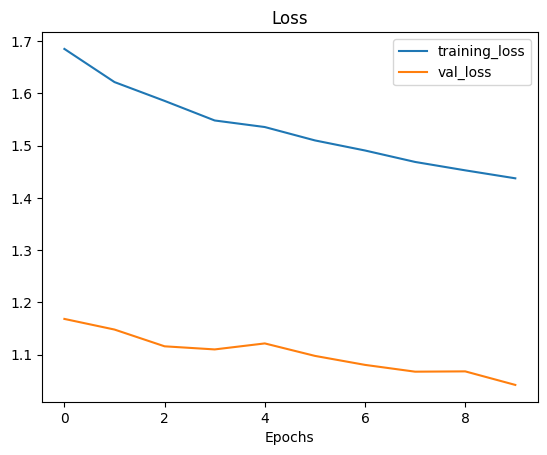

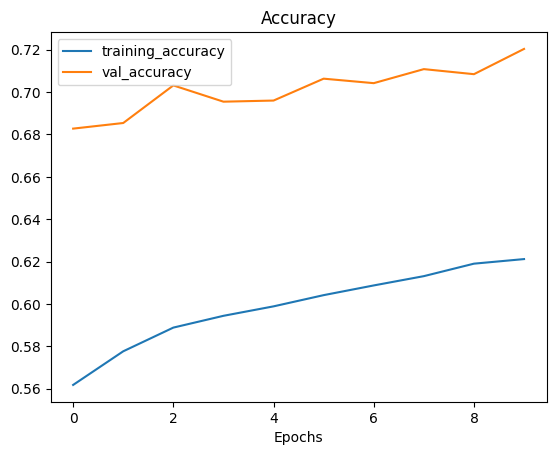

In [ ]:
# Plot loss curves for fine-tuned model
plot_loss_curves(history = history_1_fine_tune)

These loss curves look very impressive, and from the model's `val_accuracy` metric, we have passed the accuracy score the authors of the Food101 paper obtained!

However, we're going to be continuing some more modelling experiments to see the maximum accuracy score we can achieve, most likely from using pretrained ImageNet models from TensorFlow Hub: https://www.tensorflow.org/hub

> 🔑 **Note:** **Fine-tuning** a model leverages the power of transfer learning, drastically improving accuracy metrics (both training and validation) and hence, giving the ideal position for the loss curves (i.e. accuracy up and loss down).

## Model 2: Tiny VGG architecture

Model 2's architecture will be represented as the one from the Tiny VGG model architecture: https://poloclub.github.io/cnn-explainer/

In [ ]:
# Create model 2 (TinyVGG architecture) with rescaling layer
model_2 = tf.keras.Sequential([
    layers.Input(shape = input_size),
    layers.Rescaling(1./255),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D(64, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    layers.BatchNormalization(),
    layers.Conv2D(128, 3, padding = 'same', activation = 'relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation = 'softmax')
])

# Compile
model_2.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Get model summary
model_2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 224, 224, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 112, 112, 128)  │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │    40,542,309 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,803,237 (155.65 MB)

 Trainable params: 40,802,853 (155.65 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
# Fit
history_2 = model_2.fit(train_data, epochs = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_1'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_1/20250708-111425
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 645s 145ms/step - accuracy: 0.0096 - loss: 15.7179 - val_accuracy: 0.0114 - val_loss: 15.9346
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 317s 133ms/step - accuracy: 0.0094 - loss: 15.9661 - val_accuracy: 0.0114 - val_loss: 15.9346
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 318s 133ms/step - accuracy: 0.0094 - loss: 15.9662 - val_accuracy: 0.0114 - val_loss: 15.9346
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 320s 133ms/step - accuracy: 0.0094 - loss: 15.9672 - val_accuracy: 0.0114 - val_loss: 15.9346
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 321s 133ms/step - accuracy: 0.0094 - loss: 15.9658 - val_accuracy: 0.0114 - val_loss: 15.9346
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 319s 133ms/step - accuracy: 0.0094 - loss: 15.9662 - val_accuracy: 0.0114 - val_loss: 15.9346
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 324s 134ms/step - accuracy: 0.00

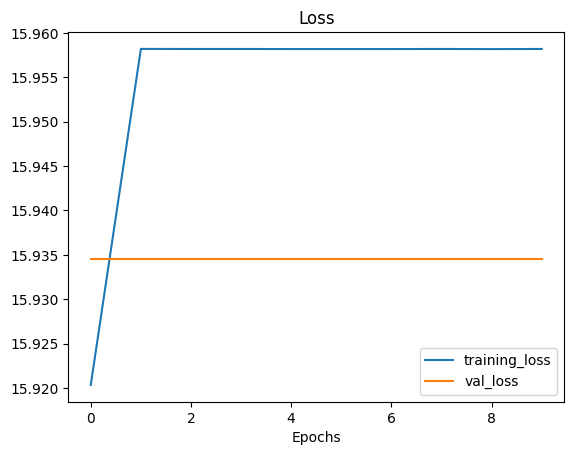

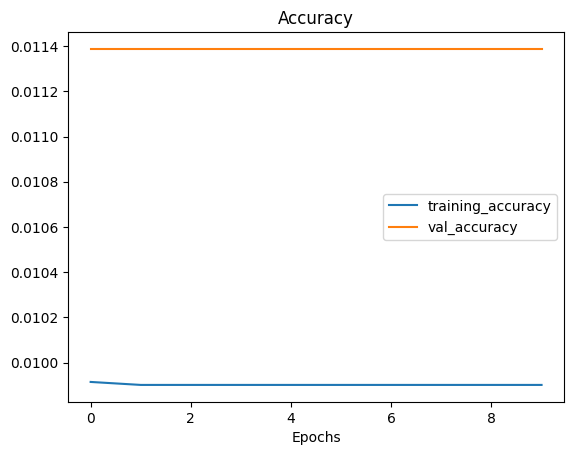

In [ ]:
# Plot loss curves
plot_loss_curves(history = history_2)

In [ ]:
# Evaluate model
model_2.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 72s 91ms/step - accuracy: 0.0102 - loss: 15.9541


[15.958532333374023, 0.009900989942252636]

In [ ]:
# Make predictions with model
model_2_preds = model_2.predict(test_data)
model_2_preds[:1]

790/790 ━━━━━━━━━━━━━━━━━━━━ 70s 87ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0.]], dtype=float16)

In [ ]:
# Convert model preds to label format
labels = model_2_preds.argmax(axis = 1)
labels[:10]

array([43, 43, 43, 43, 43, 43, 43, 43, 43, 43])

Here, we can see that the modek us predicing only 1 class for each train food101 image we fed it.

We see that the TinyVGG model architecture performs very poorly on the dataset fed into it, hinting that for larger datasets, it is simply not learning anything from the train dataset.

## Model 3: Pretrained Feature-extraction ResNet101 architecture

In [ ]:
from tensorflow.keras import layers

input_shape = (224, 224, 3)
num_classes = ds_info.features['label'].num_classes

# Create feature extractor model
base_model = tf.keras.applications.ResNet101(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')
base_model.trainable = False

inputs = layers.Input(shape = input_size, name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile the model
model_3.compile(
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'])

# Get model summary
model_3.summary()

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet101 (Functional)          │ (None, 7, 7, 2048)     │    42,658,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,216,869 (164.86 MB)

 Trainable params: 554,597 (2.12 MB)

 Non-trainable params: 42,662,272 (162.74 MB)

In [ ]:
# Fit feature-extration model
history_3 = model_3.fit(train_data, epochs = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_3'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_3/20250708-121534
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 267s 102ms/step - accuracy: 0.2000 - loss: 3.7883 - val_accuracy: 0.4711 - val_loss: 2.1220
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 239s 96ms/step - accuracy: 0.3360 - loss: 2.7839 - val_accuracy: 0.4942 - val_loss: 2.0245
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 266s 98ms/step - accuracy: 0.3612 - loss: 2.6618 - val_accuracy: 0.5037 - val_loss: 1.9330
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 238s 99ms/step - accuracy: 0.3764 - loss: 2.5751 - val_accuracy: 0.5177 - val_loss: 1.9208
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 259s 98ms/step - accuracy: 0.3930 - loss: 2.5064 - val_accuracy: 0.5355 - val_loss: 1.8492
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 98ms/step - accuracy: 0.4007 - loss: 2.4401 - val_accuracy: 0.5519 - val_loss: 1.8019
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 265s 99ms/step - accuracy: 0.4127 - loss: 2.3881 

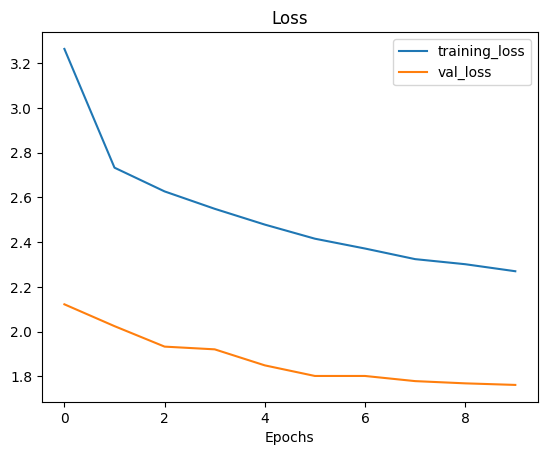

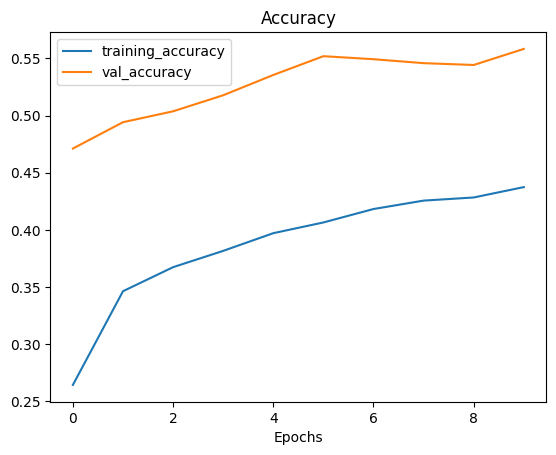

In [ ]:
# Plot loss curves
plot_loss_curves(history = history_3)

In [ ]:
# Evaluate model on test data
model_3.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 76s 96ms/step - accuracy: 0.5555 - loss: 1.7587


[1.76921808719635, 0.5519207715988159]

In [ ]:
# Make predictions with model
model_3_preds = model_3.predict(test_data)
model_3_preds[:1]

790/790 ━━━━━━━━━━━━━━━━━━━━ 85s 99ms/step


array([[2.7180e-03, 4.4703e-06, 1.2696e-05, 2.6226e-05, 2.4855e-05,
        1.3819e-03, 1.4341e-04, 6.1989e-06, 1.1086e-02, 1.2150e-03,
        5.6648e-03, 4.8280e-06, 1.5545e-03, 1.1490e-02, 7.7820e-04,
        4.9686e-04, 1.8494e-02, 3.6931e-04, 1.4305e-06, 4.9353e-05,
        1.6093e-06, 1.1778e-03, 3.8929e-03, 4.9353e-05, 9.9540e-06,
        4.3571e-05, 5.0962e-05, 6.2406e-05, 4.9744e-03, 1.8481e-01,
        4.2725e-03, 3.7503e-04, 7.9513e-05, 1.1921e-07, 1.4923e-02,
        2.9206e-06, 3.3569e-03, 6.5446e-05, 3.2187e-06, 3.1090e-04,
        9.0599e-06, 1.6093e-06, 4.8447e-03, 8.9407e-07, 7.7486e-07,
        1.0254e-02, 8.4043e-06, 2.7895e-05, 3.1829e-04, 3.9041e-05,
        2.8610e-06, 8.6427e-06, 3.3915e-05, 1.5478e-03, 0.0000e+00,
        1.4748e-02, 4.0016e-03, 3.5477e-04, 1.6052e-01, 1.1086e-05,
        1.7285e-06, 4.3213e-05, 5.7220e-06, 1.0133e-04, 0.0000e+00,
        1.8477e-05, 1.9951e-03, 9.1493e-05, 8.2254e-06, 1.2660e-04,
        0.0000e+00, 1.1921e-07, 1.5388e-02, 7.12

In [ ]:
# Convert model preds to labels
labels = model_3_preds.argmax(axis = 1)
labels[:10]

array([94, 81, 91, 53, 97,  6, 66, 31,  3,  6])

## Fine-tuning model 3

In [ ]:
# Unfreeze last 20 layers in base model (feature-extractor model)
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

for layer in base_model.layers[-20:]:
  if isinstance(layer, layers.BatchNormalization):
    layer.trainable = False

fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

# Recompile
model_3.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                metrics = ['accuracy'])

# Fit fine-tuned model
history_3_fine_tune = model_3.fit(train_data, epochs = total_epochs, initial_epoch = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_3'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_3/20250708-130037
Epoch 11/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 280s 107ms/step - accuracy: 0.4525 - loss: 2.1782 - val_accuracy: 0.5742 - val_loss: 1.6431
Epoch 12/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 300s 101ms/step - accuracy: 0.4748 - loss: 2.0875 - val_accuracy: 0.5903 - val_loss: 1.5975
Epoch 13/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 101ms/step - accuracy: 0.4857 - loss: 2.0263 - val_accuracy: 0.5985 - val_loss: 1.5621
Epoch 14/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 242s 101ms/step - accuracy: 0.5041 - loss: 1.9555 - val_accuracy: 0.5964 - val_loss: 1.5348
Epoch 15/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 262s 101ms/step - accuracy: 0.5090 - loss: 1.9240 - val_accuracy: 0.6054 - val_loss: 1.5153
Epoch 16/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 263s 102ms/step - accuracy: 0.5193 - loss: 1.8690 - val_accuracy: 0.6112 - val_loss: 1.4953
Epoch 17/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 261s 101ms/step - accuracy: 0.5299 - 

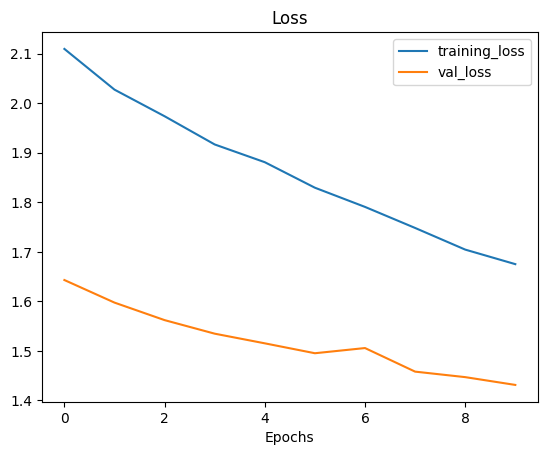

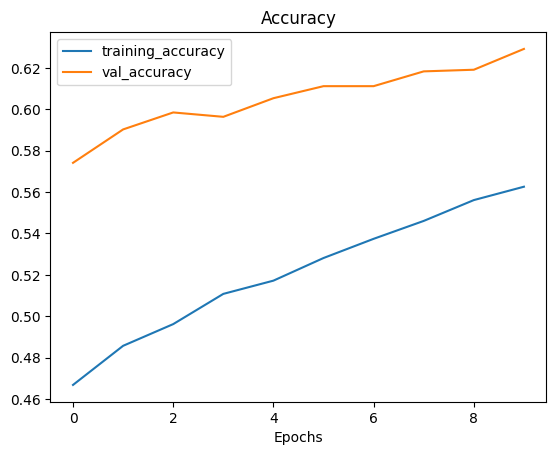

In [ ]:
# Plot loss curves for fine-tuned model
plot_loss_curves(history = history_3_fine_tune)

## Model 4: Pretrained Feature-extraction ConvNetXt-Tiny


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub

input_size = (224, 224, 3)

num_classes = ds_info.features['label'].num_classes

# Create base model
base_model = tf.keras.applications.ConvNeXtBase(include_top = False, input_shape = input_size, weights = 'imagenet')
base_model.trainable = False

# Input and preprocessing
inputs = layers.Input(shape = input_size, name = 'input_layer')
x = layers.Rescaling(1./255)(inputs) # Rescaling layer needed because ConvNetXtBase does not have rescaling built-in
x = base_model(x, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(x)

# Define model
model_4 = tf.keras.Model(inputs, outputs)

# Compile
model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Summary
model_4.summary()

350926856/350926856 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_4 (Cast)                   │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ convnext_base (Functional)      │ (None, 7, 7, 1024)     │    87,566,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,858,917 (335.16 MB)

 Trainable params: 290,405 (1.11 MB)

 Non-trainable params: 87,568,512 (334.05 MB)

In [ ]:
# Fit feature-extractor
history_4 = model_4.fit(train_data, epochs = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_4'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_4/20250708-134449
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 357s 139ms/step - accuracy: 0.1523 - loss: 3.9948 - val_accuracy: 0.3350 - val_loss: 2.7943
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 361s 134ms/step - accuracy: 0.2536 - loss: 3.2363 - val_accuracy: 0.3525 - val_loss: 2.6893
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 320s 134ms/step - accuracy: 0.2724 - loss: 3.1292 - val_accuracy: 0.3565 - val_loss: 2.6583
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 322s 134ms/step - accuracy: 0.2792 - loss: 3.0740 - val_accuracy: 0.3620 - val_loss: 2.6502
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 322s 134ms/step - accuracy: 0.2938 - loss: 3.0169 - val_accuracy: 0.3851 - val_loss: 2.5787
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 322s 134ms/step - accuracy: 0.2940 - loss: 2.9931 - val_accuracy: 0.3837 - val_loss: 2.5781
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 323s 135ms/step - accuracy: 0.3027 - loss: 2

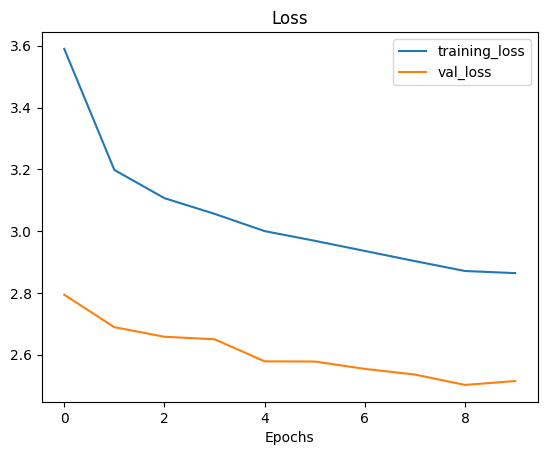

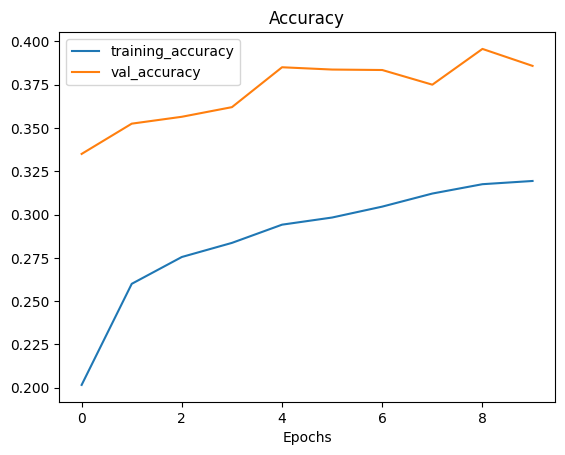

In [ ]:
# Plot loss curves
plot_loss_curves(history = history_4)

In [ ]:
# Evaluate model
model_4.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 103s 130ms/step - accuracy: 0.3916 - loss: 2.5191


[2.527322769165039, 0.38934653997421265]

In [ ]:
# Make predictions with feature-extractor
model_4_preds = model_4.predict(test_data)
model_4_preds[:1]

790/790 ━━━━━━━━━━━━━━━━━━━━ 109s 131ms/step


array([[2.1561e-02, 1.7662e-03, 1.2875e-03, 6.7854e-04, 1.1854e-03,
        2.1057e-03, 6.1750e-04, 4.6730e-03, 1.0632e-01, 8.1787e-03,
        8.3008e-03, 2.1267e-04, 2.5360e-02, 1.5930e-02, 1.3626e-02,
        1.8082e-03, 1.5297e-02, 6.1913e-03, 1.2331e-03, 4.6921e-03,
        1.8764e-04, 1.8326e-02, 3.9185e-02, 3.8433e-03, 2.9635e-04,
        1.2379e-03, 3.4847e-03, 8.7128e-03, 2.0444e-04, 1.7365e-02,
        1.5650e-03, 3.3512e-03, 8.8072e-04, 1.7285e-05, 1.8435e-03,
        1.0920e-03, 1.7914e-02, 1.4410e-03, 7.8344e-04, 1.9407e-03,
        3.6454e-04, 5.4312e-04, 6.7711e-03, 3.1490e-03, 3.8815e-04,
        1.3626e-02, 4.3440e-04, 8.2111e-04, 4.6539e-03, 1.6203e-03,
        2.4271e-04, 1.2970e-03, 3.5453e-04, 6.9466e-03, 8.1658e-05,
        4.1695e-03, 2.6302e-03, 1.1902e-03, 4.5929e-02, 2.0611e-04,
        4.7565e-04, 3.4561e-03, 1.8225e-03, 8.6737e-04, 1.6236e-04,
        4.3130e-04, 3.2410e-02, 1.4811e-03, 1.9102e-03, 7.8049e-03,
        3.8385e-05, 1.9321e-03, 1.7593e-02, 7.46

In [ ]:
# Convert preds to labels
labels = model_4_preds.argmax(axis = 1)
labels[:10]

array([100,  81,  44,  80,  97,  36,  10,  31,   3,   6])

## Fine-tuning model 4

In [ ]:
# Unfreeze last 20 layers of base model
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

for layer in base_model.layers[-20:]:
  if isinstance(layer, layers.BatchNormalization):
    layer.trainable = False

# Recompile fine-tuned model
model_4.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                metrics = ['accuracy'])

# Fit fine-tuned model
history_4_fine_tune = model_4.fit(train_data, epochs = total_epochs, initial_epoch = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.15 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_4'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_4/20250708-144321
Epoch 11/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 654s 261ms/step - accuracy: 0.3268 - loss: 2.8137 - val_accuracy: 0.4025 - val_loss: 2.4461
Epoch 12/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 654s 255ms/step - accuracy: 0.3379 - loss: 2.7621 - val_accuracy: 0.4145 - val_loss: 2.4353
Epoch 13/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 606s 255ms/step - accuracy: 0.3475 - loss: 2.7196 - val_accuracy: 0.4142 - val_loss: 2.4025
Epoch 14/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 624s 256ms/step - accuracy: 0.3494 - loss: 2.6939 - val_accuracy: 0.4076 - val_loss: 2.4065
Epoch 15/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 619s 254ms/step - accuracy: 0.3556 - loss: 2.6722 - val_accuracy: 0.4102 - val_loss: 2.3917
Epoch 16/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 621s 254ms/step - accuracy: 0.3573 - loss: 2.6626 - val_accuracy: 0.4206 - val_loss: 2.3924
Epoch 17/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 622s 254ms/step - accuracy: 0.3612 - 

Though fine-tuning model 4 did improve model metrics, it still wasn't enough to beat the Food101 paper accuracy score (~56.75%).

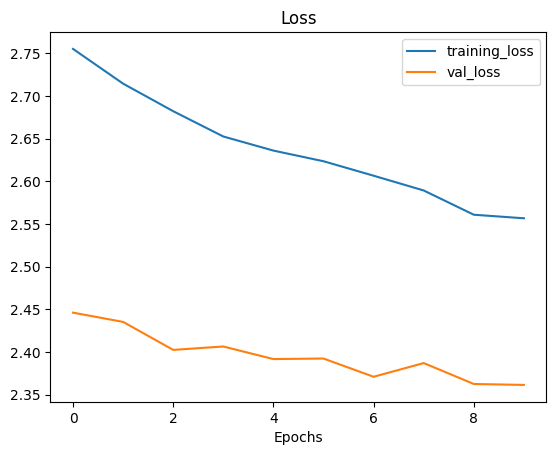

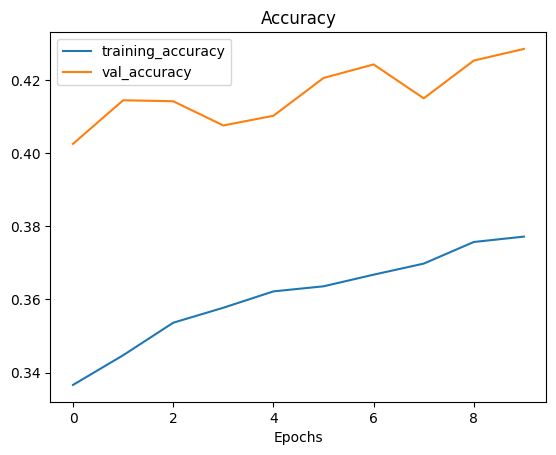

In [ ]:
# Plot loss curves for fine-tuned model
plot_loss_curves(history = history_4_fine_tune)

## Model 5: Feature-extraction (EfficientNetB7)

In [ ]:
# Define input size
input_size = (224, 224, 3)

num_classes = ds_info.features['label'].num_classes

# Create base model
base_model = tf.keras.applications.EfficientNetB7(include_top = False, input_shape = input_size, weights = 'imagenet')
base_model.trainable = False

# Input and preprocessing
inputs = layers.Input(shape = input_size, name = 'input_layer')
x = base_model(inputs, training = False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(num_classes, activation = 'softmax', name = 'output_layer')(x)
model_5 = tf.keras.Model(inputs, outputs)

# Compile
model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# Summary
model_5.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb7 (Functional)     │ (None, 7, 7, 2560)     │    64,097,687 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 2560)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 2560)           │        10,240 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       655,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 101)            │        25,957 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,789,500 (247.15 MB)

 Trainable params: 686,693 (2.62 MB)

 Non-trainable params: 64,102,807 (244.53 MB)

In [ ]:
# Fit
history_5 = model_5.fit(train_data, epochs = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.1 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_5'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_5/20250708-170400
Epoch 1/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 443s 154ms/step - accuracy: 0.2722 - loss: 3.4361 - val_accuracy: 0.5467 - val_loss: 1.7473
Epoch 2/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 321s 134ms/step - accuracy: 0.4042 - loss: 2.4719 - val_accuracy: 0.5593 - val_loss: 1.6861
Epoch 3/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 321s 134ms/step - accuracy: 0.4250 - loss: 2.3635 - val_accuracy: 0.5771 - val_loss: 1.6401
Epoch 4/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 323s 135ms/step - accuracy: 0.4439 - loss: 2.2745 - val_accuracy: 0.5953 - val_loss: 1.5505
Epoch 5/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 382s 135ms/step - accuracy: 0.4542 - loss: 2.2085 - val_accuracy: 0.6013 - val_loss: 1.5169
Epoch 6/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 380s 134ms/step - accuracy: 0.4684 - loss: 2.1481 - val_accuracy: 0.6135 - val_loss: 1.5016
Epoch 7/10
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 322s 135ms/step - accuracy: 0.4807 - loss: 2

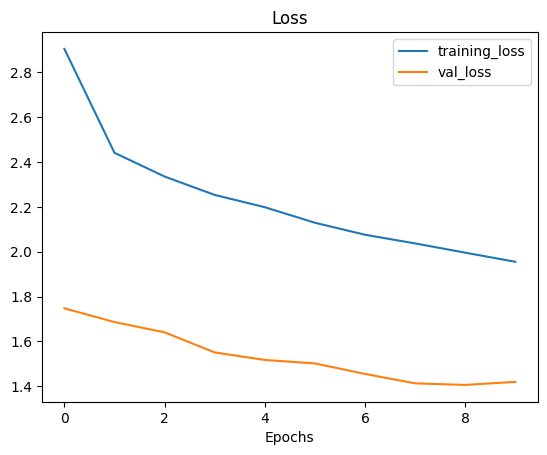

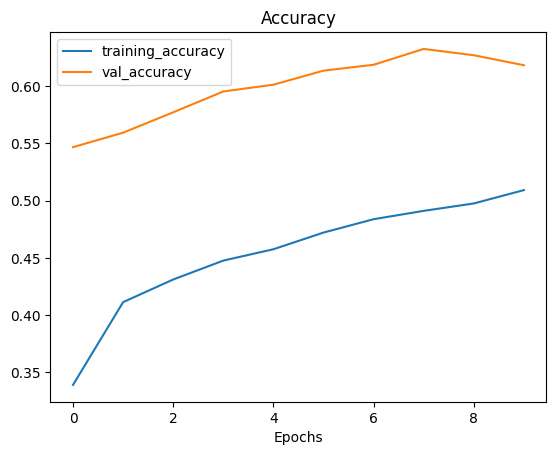

In [ ]:
# Plot loss curves
plot_loss_curves(history = history_5)

In [ ]:
# Evaluate model
model_5.evaluate(test_data)

790/790 ━━━━━━━━━━━━━━━━━━━━ 110s 139ms/step - accuracy: 0.6320 - loss: 1.3923


[1.4002346992492676, 0.6305742859840393]

In [ ]:
# Make predictions
model_5_preds = model_5.predict(test_data)
model_5_preds[:1]

790/790 ━━━━━━━━━━━━━━━━━━━━ 132s 146ms/step


array([[6.9695e-03, 8.2731e-05, 1.4172e-03, 9.4175e-05, 2.1343e-03,
        1.6241e-03, 3.4714e-04, 1.5271e-04, 2.8046e-02, 4.4918e-04,
        8.5211e-04, 2.1935e-05, 6.7711e-03, 4.3793e-03, 1.1536e-02,
        1.5078e-03, 8.7891e-02, 5.7487e-03, 9.5367e-07, 1.3328e-04,
        1.2398e-05, 9.4681e-03, 3.0762e-02, 7.9880e-03, 6.8545e-05,
        4.3035e-04, 3.9339e-04, 6.1150e-03, 2.8610e-03, 2.7734e-01,
        1.2732e-01, 2.0447e-03, 3.3116e-04, 1.6689e-06, 3.0346e-03,
        1.1718e-04, 2.5797e-04, 3.1114e-04, 2.5630e-05, 7.6103e-04,
        1.8787e-04, 3.0935e-05, 2.5539e-03, 1.4293e-04, 1.5199e-05,
        1.4557e-02, 1.0836e-04, 5.2118e-04, 9.2328e-05, 3.0160e-04,
        1.9848e-04, 1.0848e-05, 2.9111e-04, 1.3649e-04, 2.3842e-07,
        8.4209e-04, 5.6362e-04, 2.4643e-03, 3.4515e-02, 1.1313e-04,
        8.6010e-05, 6.2943e-05, 7.3767e-04, 2.9392e-03, 2.6226e-06,
        3.5048e-05, 4.2844e-04, 3.0994e-04, 4.7612e-04, 1.7047e-04,
        3.9339e-06, 1.0729e-06, 1.0818e-02, 7.93

In [ ]:
# Convert predictions to labels
labels = model_5_preds.argmax(axis = 1)
labels[:10]

array([29, 81, 57, 53, 97, 97, 67, 31,  3, 94])

## Fine-tuning model 5

In [ ]:
# Unfreeze first 20 layers
base_model.trainable = True
for layer in base_model.layers[:-20]:
  layer.trainable = False

for layer in base_model.layers[-20:]:
  if isinstance(layer, layers.BatchNormalization):
    layer.trainable = False

# Recompile
model_5.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-5),
                metrics = ['accuracy'])

# Fit
history_5_fine_tune = model_5.fit(train_data, epochs = total_epochs, initial_epoch = initial_epochs, steps_per_epoch = len(train_data), validation_data = test_data, validation_steps = int(0.1 * len(test_data)), callbacks = [create_tensorboard_callback(dir_name = './tensorflow_logs', experiment_name = 'food_101_all_modelling_experiments/model_5'), model_checkpoint])

Saving TensorBoard log files to: ./tensorflow_logs/food_101_all_modelling_experiments/model_5/20250708-180741
Epoch 11/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 456s 161ms/step - accuracy: 0.5264 - loss: 1.8688 - val_accuracy: 0.6499 - val_loss: 1.3159
Epoch 12/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 356s 139ms/step - accuracy: 0.5420 - loss: 1.7817 - val_accuracy: 0.6539 - val_loss: 1.2953
Epoch 13/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 383s 140ms/step - accuracy: 0.5518 - loss: 1.7408 - val_accuracy: 0.6630 - val_loss: 1.2825
Epoch 14/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 381s 139ms/step - accuracy: 0.5616 - loss: 1.7025 - val_accuracy: 0.6665 - val_loss: 1.2616
Epoch 15/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 382s 140ms/step - accuracy: 0.5673 - loss: 1.6628 - val_accuracy: 0.6693 - val_loss: 1.2224
Epoch 16/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 334s 140ms/step - accuracy: 0.5755 - loss: 1.6369 - val_accuracy: 0.6697 - val_loss: 1.2290
Epoch 17/20
2368/2368 ━━━━━━━━━━━━━━━━━━━━ 333s 140ms/step - accuracy: 0.5774 - 

 Though model 5 was able to beat the accuracy score of the Food101 paper, model 1 still outperformed model 5 by ~4%.

 > 🔑 **Note:** Not all pretrained models from TensorFlow Hub will be able to beat the Food101 accuracy metric, despite their weights trained from ImageNet.

 For example, in our modelling experiments, model 1 (EfficientNetB0) has a simple pretrained model that outperformed model 5 (EfficientNetB2) which has a complex architecture. So, there are other factors to consider when picking a pretrained model, such as model size and its number of parameters. Using a larger model does not necessarily mean that you will get a better accuracy metric.

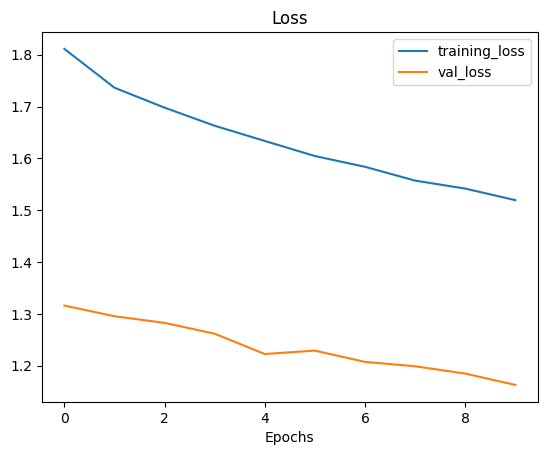

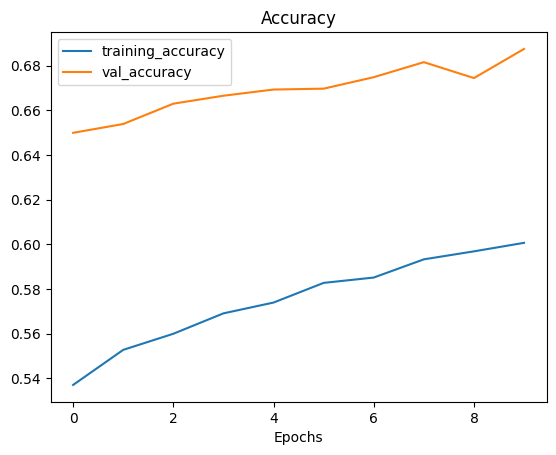

In [ ]:
# Plot fine-tuned results
plot_loss_curves(history = history_5_fine_tune)

## Uploading our model results to TensorBoard

We're now going to be uploading our modelling experiments to TensorBoard, so we can view each of our model's training logs: https://www.tensorflow.org/tensorboard

In [ ]:
# Upload models' results to TensorBoard
!pip install -q tensorboard
%load_ext tensorboard
%tensorboard --logdir=/content/tensorflow_logs